In [ ]:
import os
import glob
import pickle

import tensorflow as tf
import numpy as np
from drift.robots import ETHModel
from collections import deque
from drift.models.ddpg import DDPG, DDPGParams, DDPGSummary
from drift.commons import ParamsBase
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.transforms import Affine2D
from numpy import genfromtxt
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
class Params(DDPGParams, ParamsBase):
    """Params class"""
    # path to base path containing models and params.json
    base_path = "/home/zadiq/dev/@p/drift_project/data/02-03-2019/ddpg_run_4"

    # the episode of the model that will be inferred
    episode = 108

    
def load_eth_model(params):
    eth = ETHModel(
        imp=params.dynamics,
        reward_version=params.reward_version,
        ds=params.ds,
        reward_params=params.reward_params
    )
    return eth


def infer(params):
    """
    Load and infer a model based on
    params config.
    """
    tf.reset_default_graph()
    with tf.Session() as sess:
        
        # set random random seed for reproducibility
        np.random.seed(params.seed)
        tf.random.set_random_seed(params.seed)
    
        eth = load_eth_model(params)
        
        ddpg = DDPG(params, sess)
        summary = DDPGSummary(sess)
        sess.run(tf.global_variables_initializer())
        
        # load and restore weights
        model_path = os.path.join(
            params.base_path, "model",
            f"eps-{params.episode}*"
        )
        model_path = glob.glob(model_path)[0].split(".")
        model_path = ".".join(model_path[:2])
        summary.load_model(model_path)

        dt = 0
        # deque sequence for stacking states
        state_sequence = deque(
            [np.zeros(params.state_dim) for _ in range(params.stack_len)],
            maxlen=params.stack_len
        )
        inf_reward = []

        while dt < params.drive_dur:
            current_state = eth.get_state().to_array()
            state_sequence.append(current_state)

            ss = state_sequence.copy()
            ss.reverse()
            cs = np.array(ss).ravel().reshape(1, -1)
            action = (ddpg.predict(cs) + 0).ravel()[0]
            _, _, reward, _, _ = eth(action, duty_cycle=1)
            inf_reward.append(reward)

            dt += eth.variables.dt

            eth.sequence(eth.variables.group)

        eth.inf_reward = np.array(inf_reward)
    
    return eth


def _m(path):
    """Join base path with path to model"""
    return os.path.join("/home/zadiq/dev/@p/auto_drift/data", path)


def score_model(eth, output=True):
    t_reward = eth.inf_reward.sum()
    max_reward = eth.inf_reward.max()
    mean_reward = eth.inf_reward.mean()
    scores = {
        "Total Reward: ": t_reward,
        "Max Reward: ": max_reward,
        "Mean Reward: ": mean_reward,
    }
    if output:
        print(scores)
    return scores
    

In [290]:
class PlotDrift:
    
    def __init__(self, ax, sequence, rewards, info, cmap="winter"):
        self.yaw = np.array(sequence['0_yaw']) % (2 * np.pi)
        self.x_array = np.array(sequence['0_X'])
        self.y_array = np.array(sequence['0_Y'])
        self.sequence = sequence
        self.rewards = rewards
        self.ax = ax
        self.info = info
        self.cmap = cmap
        
    def get_robot(self, alpha=1):
        """
        alpha: colour alpha
        :return: robot, robot_head
        """
        r = {  # robot patch parameters
            'w': 6,  # width
            'h': 3,  # height
            'hw': 1,  # head width
        }
        
        scale_factor = max(abs(self.x_array).max(), abs(self.y_array).max())
        scale = 110 / scale_factor  # scale down
        robot_shape = np.array([r['w'], r['h']]) / scale
        robot = plt.Rectangle((0, 0), *robot_shape, fc="red")
        head_shape = np.array([r['hw'], r['h']]) / scale
        robot_head = plt.Rectangle((0, 0), *head_shape, fc="black")
        
        return robot, robot_head        
    
    def plot(self, robot_num=5, up_to=2000):
        self.plot_ticks()
        self.plot_lines(up_to)
        self.plot_texts()
        X = self.x_array[:up_to]
        Y = self.y_array[:up_to]
        
        for i in range(0, X.shape[0], X.shape[0]//robot_num):
            self.plot_robot_at(i)
    
    def plot_texts(self):
        
        # scores and episode
        eps = self.info['eps']
        score = self.info['score']
        self.ax.annotate(
            f"Episode: {eps}", xy=(0.05, 0.92),
            xycoords='axes fraction', size=14,
            weight="bold"
        )
          
        self.ax.set_title("$r_{T, inf}$ =" + f"{score}", size=14)
        if self.info['x_label']:
            self.ax.set_xlabel("$x$ (m)", size=14)
            
        if self.info['y_label']:
            self.ax.set_ylabel(f"$y$ (m)", size=14)
    
    def plot_ticks(self):
        self.ax.yaxis.set_ticks_position('both')
        self.ax.xaxis.set_ticks_position('both')
        
        self.ax.yaxis.set_major_locator(plt.MultipleLocator(2))
        self.ax.xaxis.set_major_locator(plt.MultipleLocator(2))
        
        self.ax.yaxis.set_minor_locator(plt.MultipleLocator(1))
        self.ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
        
        self.ax.tick_params('both', direction='inout')
    
    def old_plot_lines(self, up_to=2000):
        X = self.x_array[:up_to]
        Y = self.y_array[:up_to]
        rewards = self.rewards[:up_to]
        cm = plt.get_cmap(self.cmap)
        
        for r, c in zip(np.arange(-1, 0.1, 0.1), np.arange(0, 1.1, 0.1)):
            mask = np.logical_and(rewards <= r, rewards >= (r-0.11))
            x = X[mask]
            y = Y[mask]
            self.ax.plot(x, y, color=cm(c))
                    
    def plot_lines(self, up_to=2000):
        X = self.x_array[:up_to]
        Y = self.y_array[:up_to]
        rewards = self.rewards[:up_to]
        cm = plt.get_cmap(self.cmap)
        
        seg, seg_cmap = self.segment_lines(rewards)
        for s, c in zip(seg, seg_cmap):
            x = X[s]
            y = Y[s]
            self.ax.plot(x, y, color=cm(c))
    
    def segment_lines(self, rewards):
        start_re = rewards[0]
        seg_re = [[s]]
        seg_index = [[0]]
        counter = 0
        for i, r in enumerate(rewards[1:]):
            if abs(start_re - r) >= 0.1:
                seg_index[counter].append(i+1)
                seg_re.append([])
                seg_index.append([])
                counter += 1
                start_re = r
                
            seg_re[counter].append(r)
            seg_index[counter].append(i+1)
        
        seg_cmap = [np.mean(g)+1 for g in seg_re]
        
        return seg_index, seg_cmap
        

    @staticmethod
    def set_robot_pos(robot, robot_head, pos):
        # set robot position
        w, h = robot.get_width(), robot.get_height()
        x, y = pos[0] - (w / 2), pos[1] - (h / 2)
        robot.set_xy((x, y))

        # set robot head position
        robot_head.set_xy((x + w, y))
    
    @staticmethod
    def transform_robot(robot, robot_head, t):
        robot.set_transform(t)
        robot_head.set_transform(t)
    
    def plot_robot_at(self, i):
        """
        :param i: index
        """
        x = self.x_array[i]
        y = self.y_array[i]
        t = Affine2D().rotate_around(x, y, self.yaw[i]) + self.ax.transData
        
        robot, robot_head = self.get_robot()
        self.transform_robot(robot, robot_head, t)
        self.set_robot_pos(robot, robot_head, (x, y))
        self.ax.add_patch(robot)
        self.ax.add_patch(robot_head)

In [4]:
def analyse_run(run_path):
    model_path = _m(run_path)
    params = Params.from_json(model_path)
    params.base_path = model_path
    episodes_path = glob.glob(os.path.join(model_path, "eps-*"))
    scores = {}  # for each episode, total reward scores are stored in (train, inf) scores
    models = {}
    for path in episodes_path:
        base_split = os.path.basename(path).split("-")
        train_score = int(base_split[3].split(".")[0])
        ep = params.episode = int(base_split[1])
        try:
            eth = infer(params)
            models[ep] = eth
        except Exception as e:
#             raise e
            pass
        else:
            inf_score = int(score_model(eth, False)['Total Reward: '])
            scores[ep] = (train_score, inf_score)
    
    
    def get_inf_score(ep):
        return scores[ep][1]

    print("\t Eps \t|\t Train Score \t|\t Inf Score \t")  
    print("\t --- \t|\t ----------- \t|\t --------- \t") 
    for ep in sorted(scores, key=get_inf_score):
        train, inf = scores[ep]
        print(f"\t {ep} \t|\t {train} \t\t|\t {inf} \t")
    
    return scores, models

In [209]:
model_base_paths = [
        "26-02-2019/ddpg_run_3",
        "02-03-2019/ddpg_run_1",
        "02-03-2019/ddpg_run_2",
        "02-03-2019/ddpg_run_3",
        "02-03-2019/ddpg_run_5",
        "02-03-2019/ddpg_run_6",
        "02-03-2019/ddpg_run_7",
    ]
# analysis = {}
# for path in model_base_paths:
#     print(f"\n\nAnalysing: [{path}]\n")
#     analysis[path] = analyse_run(path)



Analysing: [26-02-2019/ddpg_run_3]

	 Eps 	|	 Train Score 	|	 Inf Score 	
	 --- 	|	 ----------- 	|	 --------- 	
	 42 	|	 259 		|	 -1999 	
	 5 	|	 421 		|	 -1999 	
	 48 	|	 272 		|	 -1999 	
	 52 	|	 263 		|	 -1999 	
	 38 	|	 171 		|	 -1999 	
	 54 	|	 247 		|	 -1999 	
	 84 	|	 241 		|	 -1999 	
	 93 	|	 234 		|	 -373 	
	 79 	|	 271 		|	 -359 	
	 90 	|	 268 		|	 -317 	
	 86 	|	 285 		|	 -228 	


Analysing: [02-03-2019/ddpg_run_1]

	 Eps 	|	 Train Score 	|	 Inf Score 	
	 --- 	|	 ----------- 	|	 --------- 	
	 0 	|	 1837 		|	 -1999 	
	 52 	|	 162 		|	 -1999 	
	 39 	|	 180 		|	 -1999 	
	 48 	|	 103 		|	 -1999 	
	 15 	|	 283 		|	 -1999 	
	 12 	|	 435 		|	 -1999 	
	 28 	|	 203 		|	 -1999 	
	 37 	|	 208 		|	 -1999 	
	 40 	|	 195 		|	 -1999 	
	 24 	|	 194 		|	 -1999 	
	 45 	|	 207 		|	 -1999 	
	 64 	|	 128 		|	 -1999 	
	 33 	|	 297 		|	 -1999 	
	 14 	|	 237 		|	 -1999 	
	 19 	|	 194 		|	 -1999 	
	 46 	|	 165 		|	 -1999 	
	 3 	|	 1398 		|	 -1999 	
	 43 	|	 161 		|	 -1999 	
	 55 	|	 157 		|	 -1999

with open('eth_analysis.pkl', 'rb') as f:
    analysis = pickle.load(f)

In [19]:
class PlotGrid:
    
    def __init__(self, analysis, cmap="winter"):
        
        """
        :analysis: a tuple of two dicts: (score, models)
        """
        self.analysis = analysis
        self.cmap = cmap
    
    def _get_top_six(self):
        """get top episodes bassed on inference score"""
        scores = self.analysis[0]
        
        def get_inf_score(ep):
            return scores[ep][1]
         
        return list(reversed(sorted(scores, key=get_inf_score)))[:6]
    
    def plot(self, episodes=None, robot_num=7, max_iter=480):
        """
        :episodes: if None, then plot the top six inference scores in grid else provide a
        list of episodes to plot
        """
        episodes = episodes or self._get_top_six()
        nrows = (len(episodes) // 3) + (len(episodes) % 3 > 0)
        fig, axes = plt.subplots(ncols=3, nrows=nrows, figsize=(17, 15))
        all_axes = [*axes.flat]
        [fig.delaxes(ax) for ax in all_axes[len(episodes):]]
        models = self.analysis[1]
        
        for i, ep in enumerate(episodes):
            m = models[ep]
            ax = all_axes[i]
            info = {
                "score": int(m.inf_reward.sum()),
                "eps": ep,
                "y_label": False,
                "x_label": False
            }
            if not (i % 3):
                info['y_label'] = True
            
            if (len(episodes) - 3) <= i:
                info['x_label'] = True
                
            drift_plotter = PlotDrift(ax, m.sequence, m.inf_reward, info, self.cmap)
            drift_plotter.plot(robot_num=robot_num, up_to=max_iter)
        
        cm = plt.get_cmap(self.cmap)
        sm = plt.cm.ScalarMappable(cmap=cm, norm=plt.Normalize(vmin=-1, vmax=0))
        sm._A = []
        colorbar = fig.colorbar(sm, ax=all_axes, orientation='horizontal', shrink=1, pad=.1, aspect=90)
        colorbar.set_label('State Reward, $r_t$', size=14)
        return fig

In [389]:
font = {'weight' : 'bold',
        'size'   : 18}

matplotlib.rc('font', **font)

2D MODEL: 02-03-2019/ddpg_run_7 episode 41 for [2D Results, Reward Analysis, Predicted Action Analysis, DDPG Analysis]
    - drift graph selected best 6  -> eth_run_2_analysis_cooper
    - reward per step for episode 41 ->
    - total reward per episode for all episodes ->
    - reward per step per episode for all episodes  ->
    - action applied at episode 41 percentiled with other best  ->
    - state [vx, vy, omega] at episode 41  ->
    
    - use best model to control other dynamic models and record inference scores ->
    - bayesian search of optimal parameter ->
    - blend all bests of 2D models and infer on all 2D dynamic models -> 
    - graph of optimal weighted acton using percentile graph for best controlled optimal model ->
    - stacked graph of each dynamic model and the model that contributes the most ->
    
3D MODEL: 15-03-2019/ddpg_run_3 episode 50 for [3D Results, Reward Analysis, Predicted Action Analysis]
    - drift graph for episode 50
    - reward per step for episode 50
    - total reward per episode for all eps
    - reward per step per episode for all eps
    - action applied at episode 50 percentiled with other best
    - state [vx, vy, omega] at episode 50

## 2D

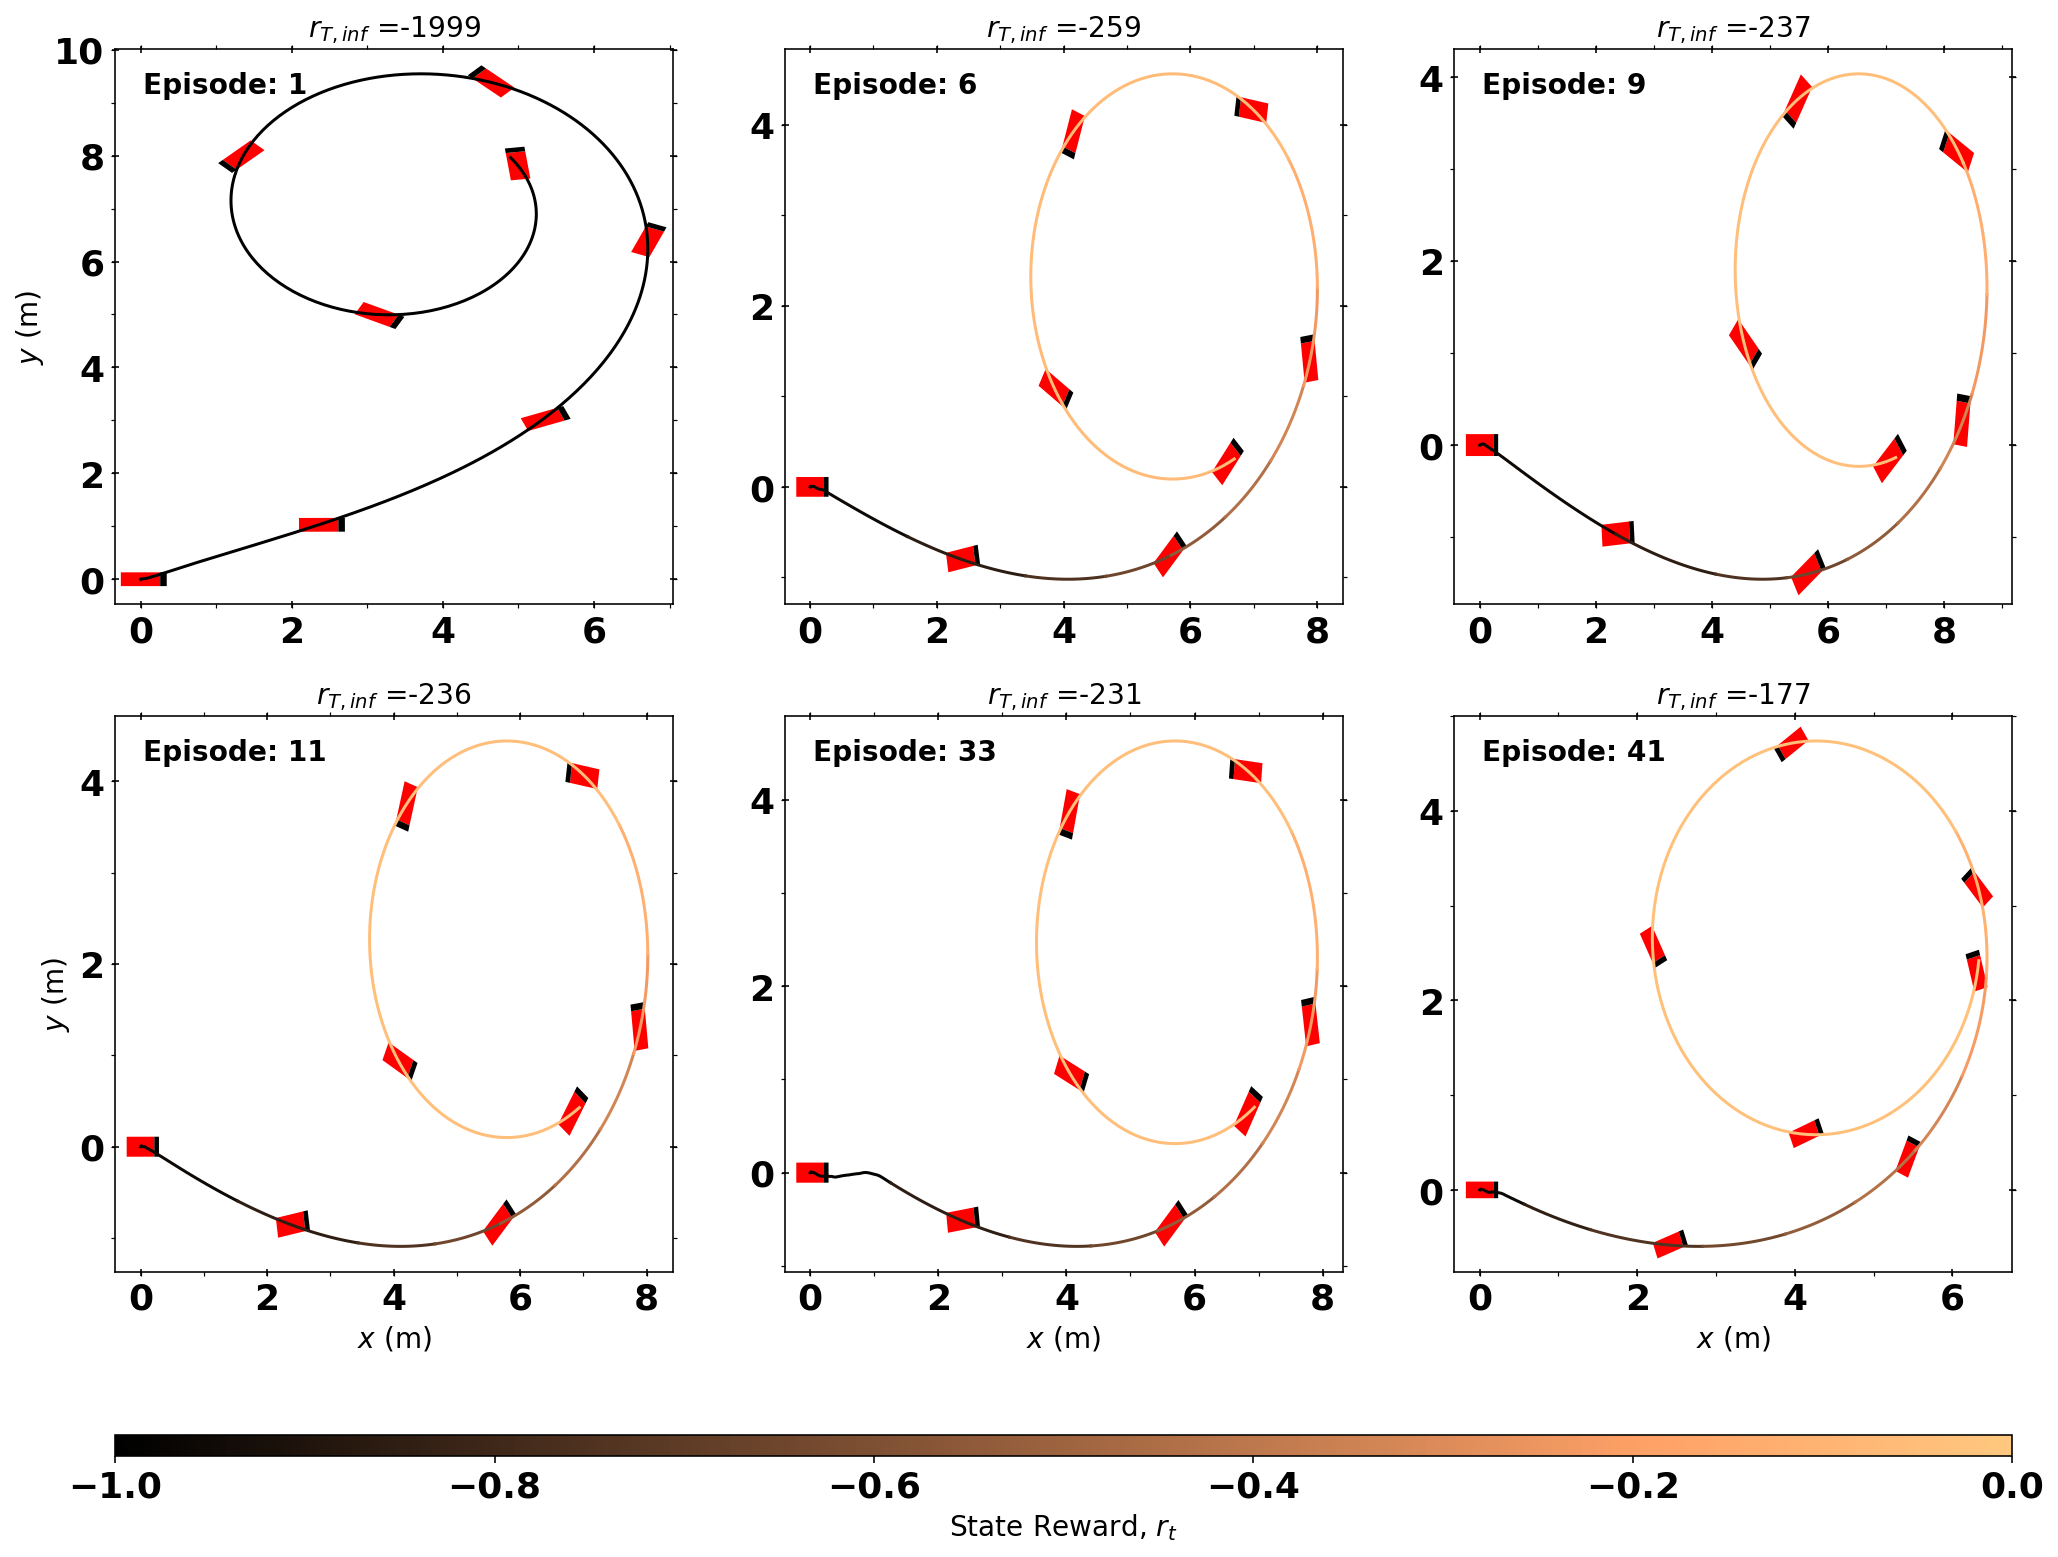

In [442]:
for cmap in ['copper']:
    grid_plotter = PlotGrid(analysis['02-03-2019/ddpg_run_7'], cmap)
    fig = grid_plotter.plot([1, 6, 9, 11, 33, 41])
    fig.savefig(f"images/eth_run_7_analysis_{cmap}.eps", format="eps", dpi=1000)
    fig.savefig(f"images/eth_run_7_analysis_{cmap}.png", format="png", dpi=500)

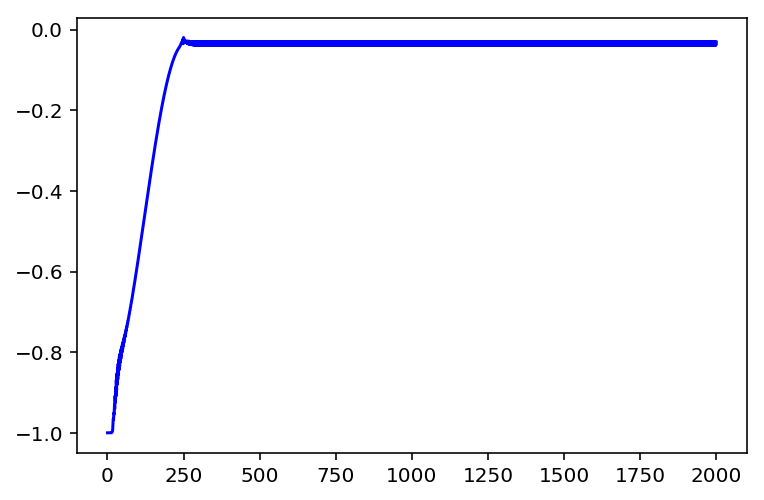

In [279]:
# reward per step for episode 41 of eth model
plt.plot(analysis['02-03-2019/ddpg_run_7'][1][41].inf_reward, color='b')
# use zoomed region inset http://akuederle.com/matplotlib-zoomed-up-inset

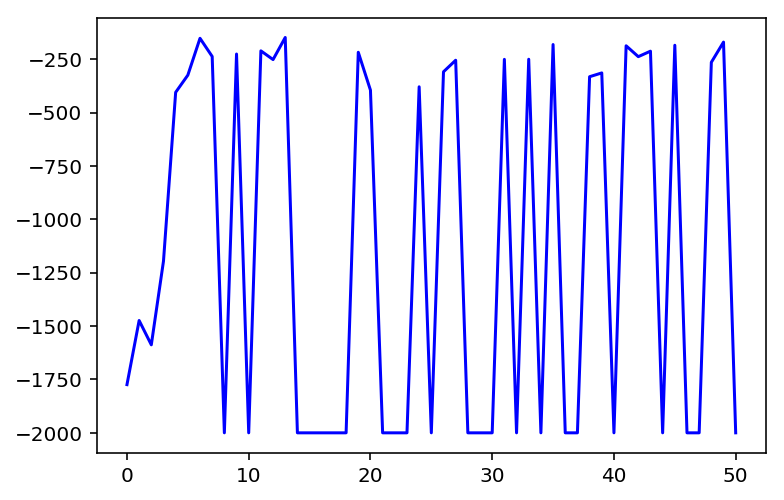

In [276]:
# Total reward per episode for all episodes of model ddgp_run_7 - from tensorboard data
"""
let the graph show 0 score, draw a line on 0 indicating max score
label episode, score, use dotted lines if possible
"""
run_7_total_rewards = genfromtxt('data/eth_run_7_episodes_total_reward.csv', delimiter=',')
sns.lineplot(data=run_7_total_rewards[1:,2], color='b')

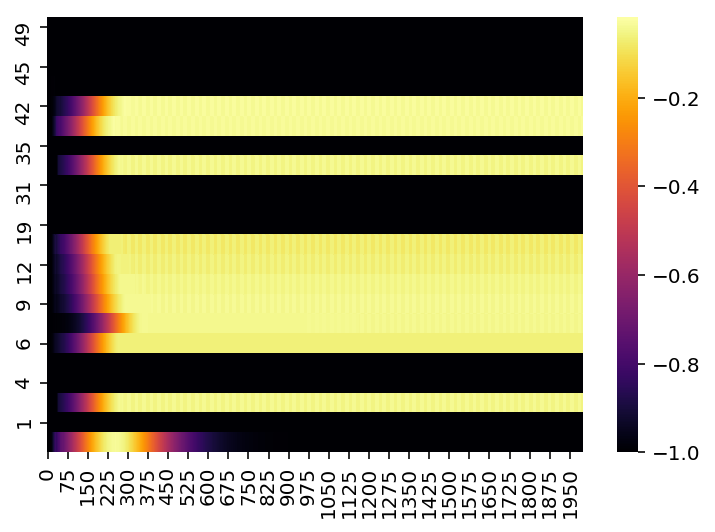

In [148]:
# Reward per step per episodes for run 7
# https://radumas.info/blog/tutorial/2017/04/17/percentile-test.html
episodes = sorted(analysis['02-03-2019/ddpg_run_7'][1].keys())
ep_step_scores = []
for ep in episodes:
    ep_step_scores.append(analysis['02-03-2019/ddpg_run_7'][1][ep].inf_reward)
ep_step_scores = np.array(ep_step_scores)
ep_step_df_2d = pd.DataFrame(ep_step_scores)
ep_step_df_2d.index = episodes
ax = sns.heatmap(ep_step_df_2d[::-1],  cmap="inferno")

/home/zadiq/dev/venvs/dl/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


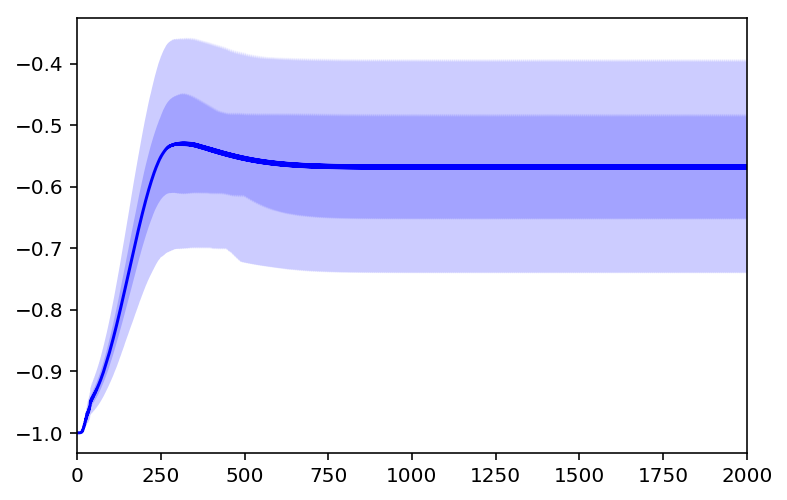

In [84]:
sns.tsplot(data=ep_step_scores, ci=[50, 90], color="b")

In [122]:
states_data = {
    'vx': [],
    'vy': [],
    'omega': [],
    'steering': []
}
for ep in [33, 41, 42]: # best three scores
    seq = analysis['02-03-2019/ddpg_run_7'][1][ep].sequence.data_as_array()
    states_data['vx'].append(seq['0_vx'])
    states_data['vy'].append(seq['0_vy'])
    states_data['omega'].append(seq['0_omega'])   
    states_data['steering'].append(seq['1_delta'] * 10)

/home/zadiq/dev/venvs/dl/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


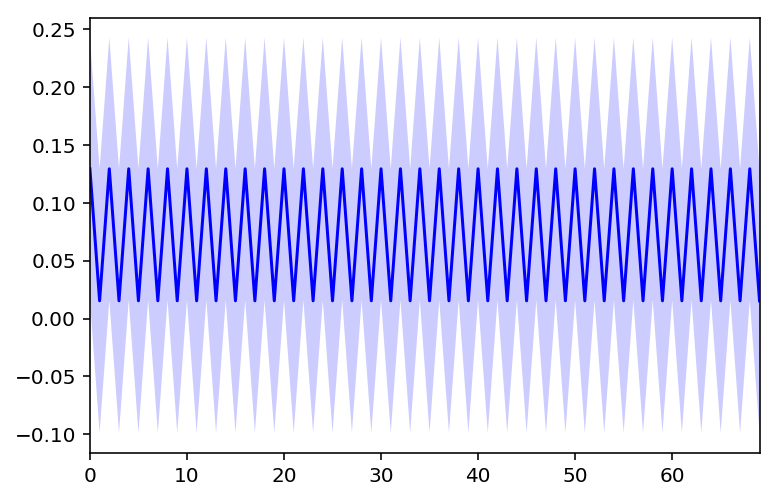

In [145]:
# steering: remove percentile but give space for height
sns.tsplot(data=np.array(states_data['steering'])[:, 1000:1070], ci=[90], color="b")

# 3D

- using ddpg_run_3
- Episode 90 has the highest score

In [161]:
with open("/home/zadiq/uni/Personal Project/data/3D Simulation/15-03-2018/ddpg_run_3/inference/analysis-actual.pkl", 'rb') as fp:
    thd_analysis = pickle.load(fp)

In [256]:
class Dummy3DModel:
    """Dummy model to make 3D analysis compatible with 2D's"""
    
    def __init__(self, reward, sequence, coord):
        self.inf_reward = reward
        ss = sequence.data_as_array()
        coord = coord.data_as_array()
        self.sequence = {
            "0_vx": ss['current_state'][:, 0],
            "0_vy": ss['current_state'][:, 1],
            "0_omega": ss['current_state'][:, 2],
            "0_X": coord['x'],
            "0_Y": coord['y'],
            "0_yaw": coord['yaw'],
            "1_delta": ss['action'],
        }

In [257]:
thd_models = {}
for i, ep in enumerate(thd_analysis['episodes']):
    thd_models[ep] = Dummy3DModel(
        thd_analysis["rewards"][i], 
        thd_analysis["sequence"][i], 
        thd_analysis["coord"][i], 
    )

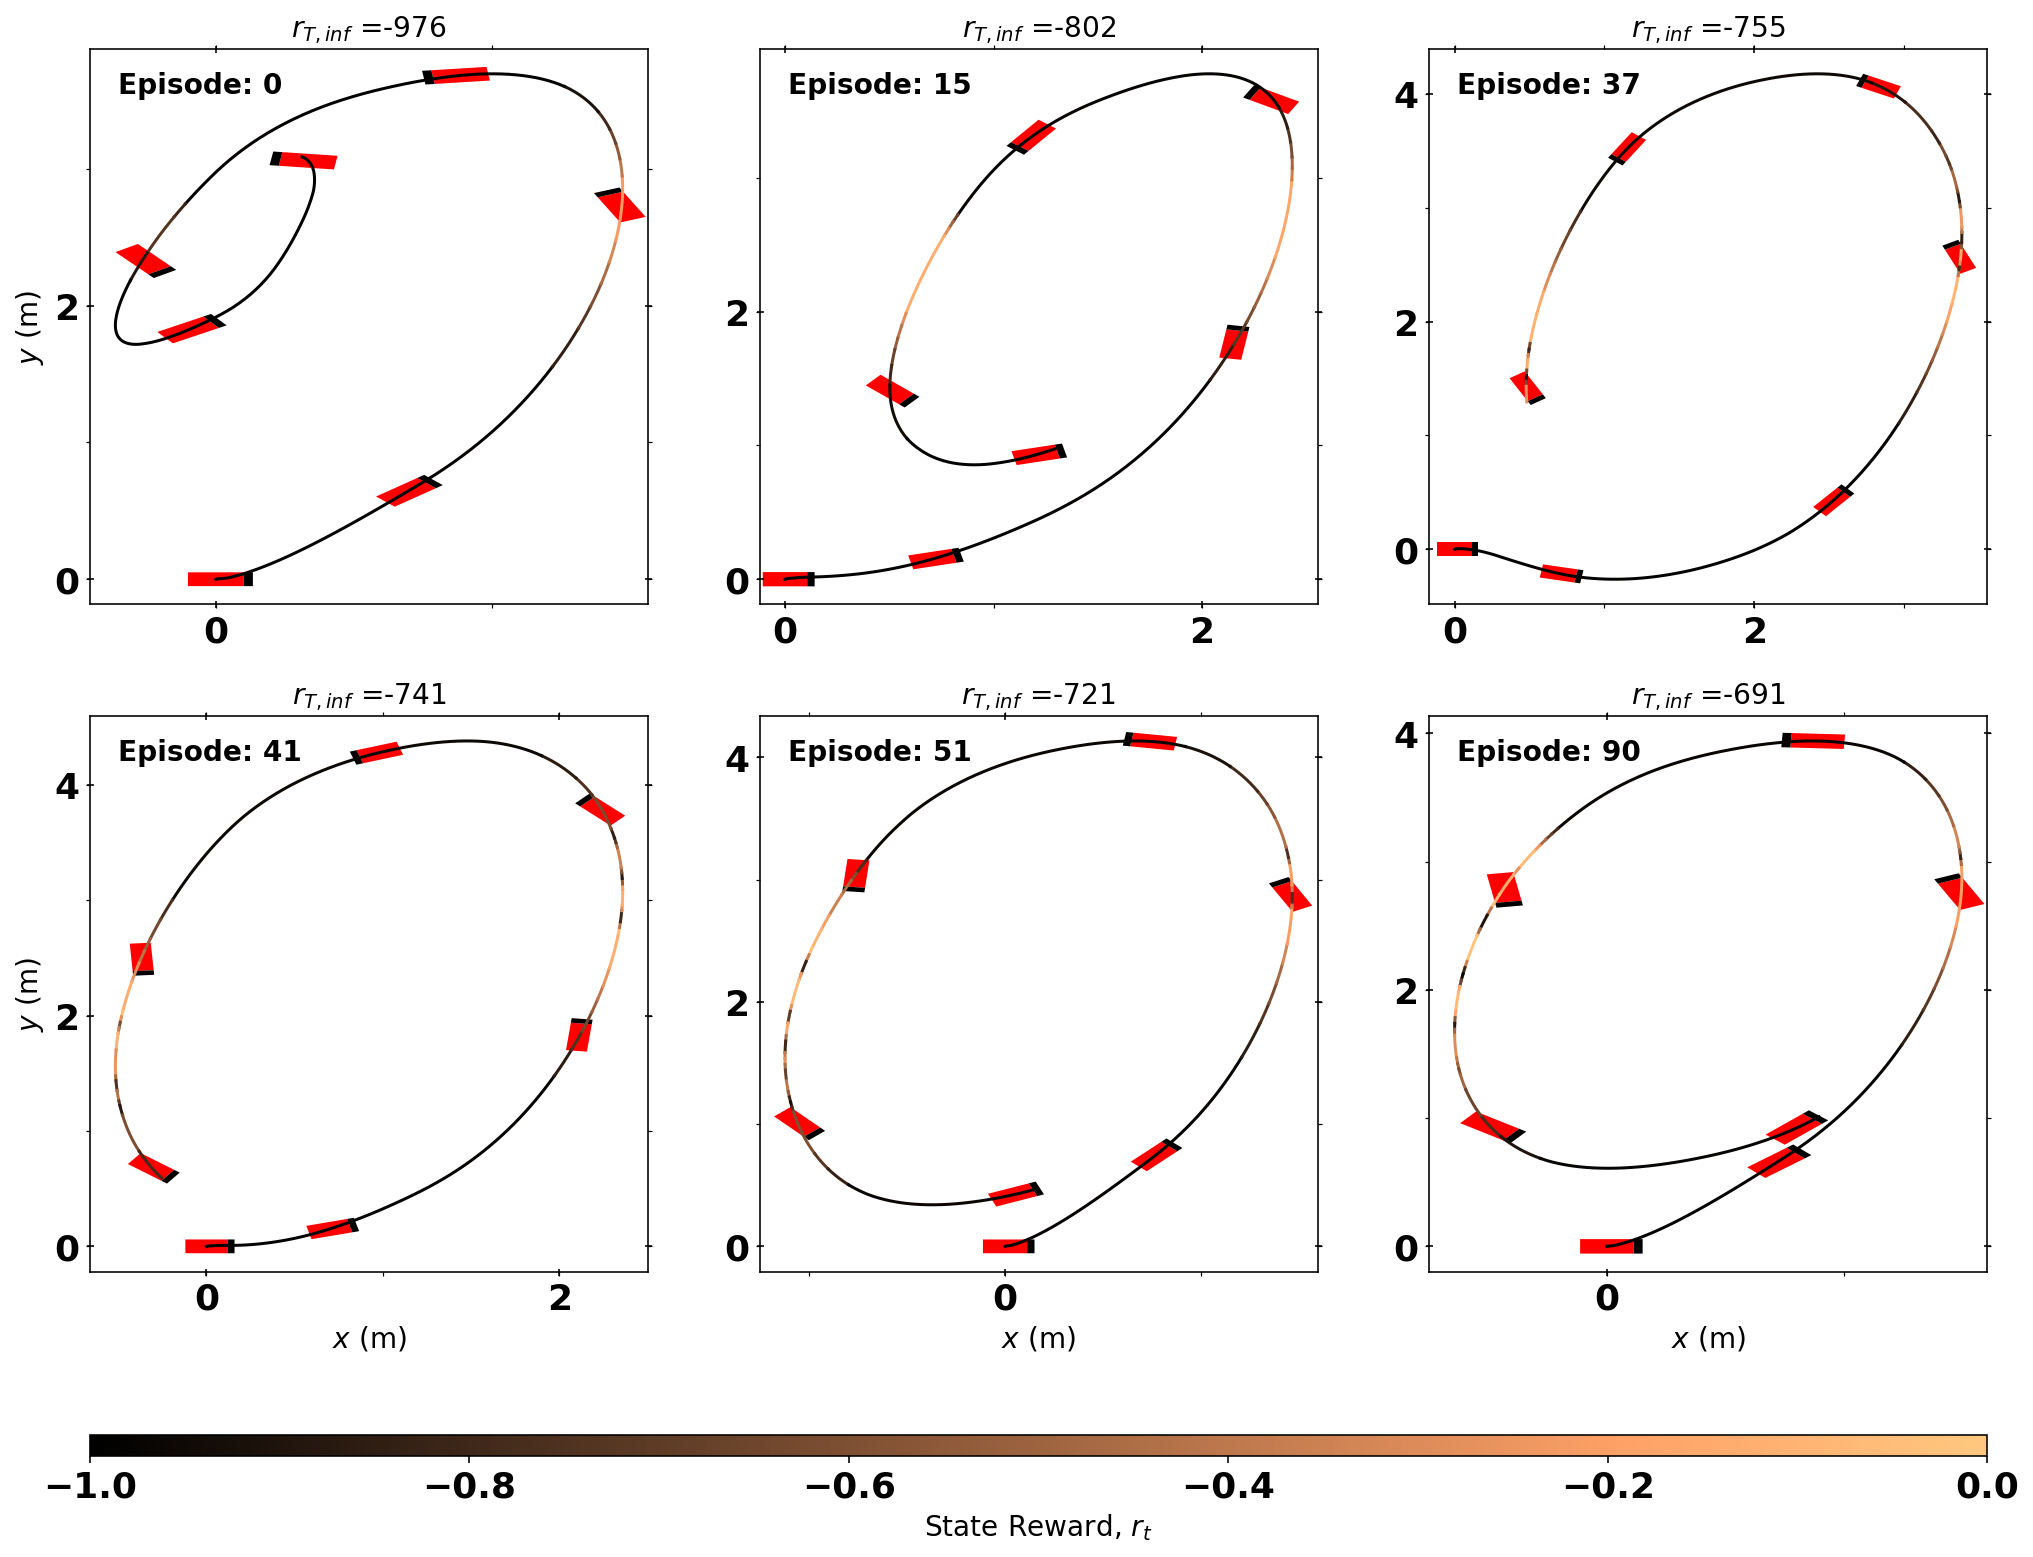

In [443]:
th_grid_plotter = PlotGrid(['', thd_models], 'copper')
fig = th_grid_plotter.plot([0, 15, 37, 41, 51, 90], max_iter=250, robot_num=6)
fig.savefig(f"images/ack_run_3_analysis_{cmap}.eps", format="eps", dpi=1000)
fig.savefig(f"images/ack_run_3_analysis_{cmap}.png", format="png", dpi=500)

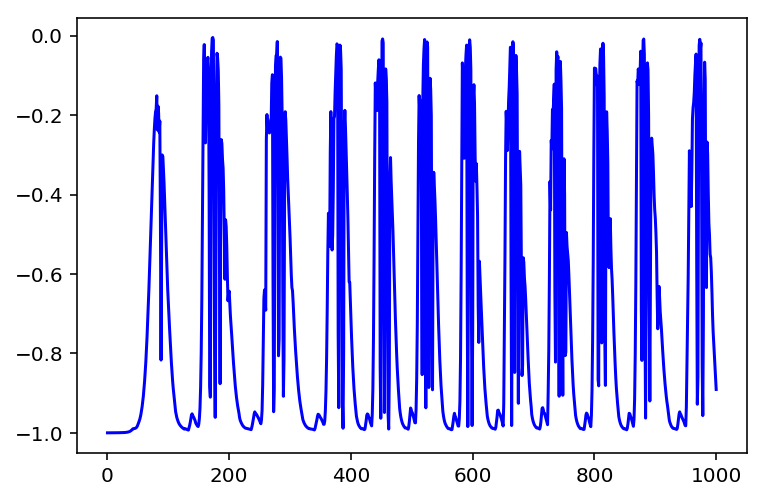

In [278]:
# reward per step for episode 90 of ackermann model
plt.plot(thd_models[90].inf_reward, color='b')

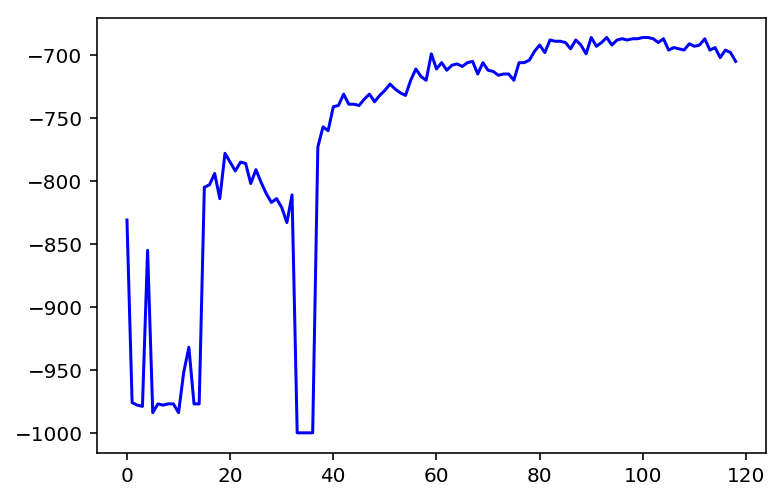

In [277]:
run_3_total_rewards = genfromtxt('data/ack_run_3_episodes_total_reward.csv', delimiter=',')
plt.plot(run_3_total_rewards[1:,2], color='b')

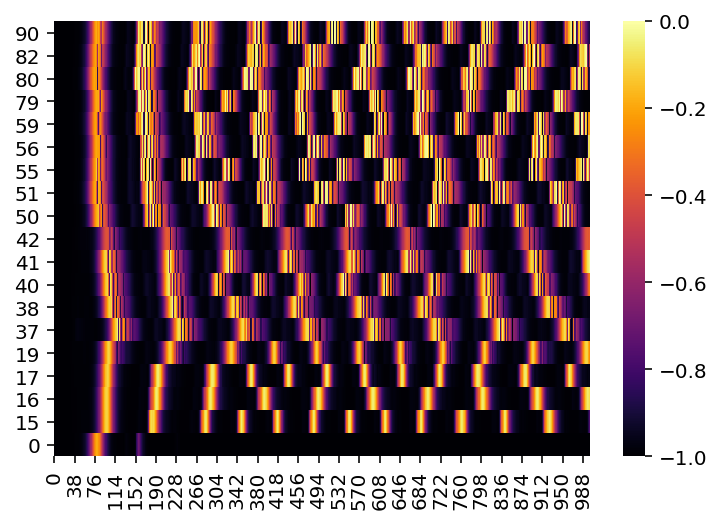

In [246]:
# Reward per step per episode
episodes = sorted(thd_analysis['episodes'])
ep_step_scores = []
for ep in episodes:
    ep_step_scores.append(thd_models[ep].inf_reward)
ep_step_scores = np.array(ep_step_scores)
ep_step_df_3d = pd.DataFrame(ep_step_scores)
ep_step_df_3d.index = episodes
ax = sns.heatmap(ep_step_df_3d[::-1],  cmap="inferno")

/home/zadiq/dev/venvs/dl/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


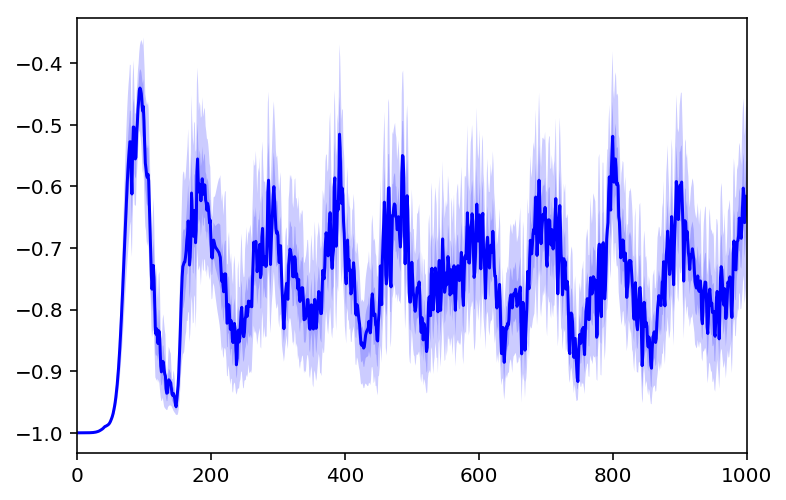

In [252]:
sns.tsplot(data=ep_step_scores, ci=[50, 90], color="b")

In [281]:
ack_states_data = {
    'vx': [],
    'vy': [],
    'omega': [],
    'steering': []
}
for ep in [80, 82, 90]: # best three scores
    seq = thd_models[ep].sequence
    ack_states_data['vx'].append(seq['0_vx'])
    ack_states_data['vy'].append(seq['0_vy'])
    ack_states_data['omega'].append(seq['0_omega'])   
    ack_states_data['steering'].append(seq['1_delta'])

/home/zadiq/dev/venvs/dl/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


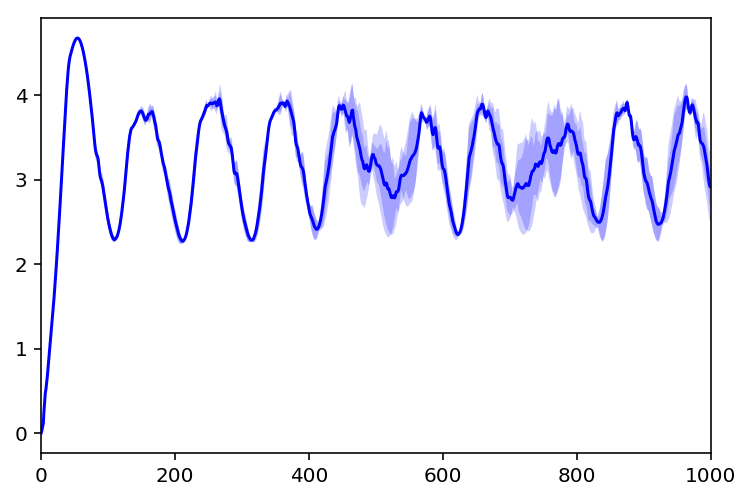

In [268]:
sns.tsplot(data=np.array(ack_states_data['vx']), ci=[50, 90], color="b")

/home/zadiq/dev/venvs/dl/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


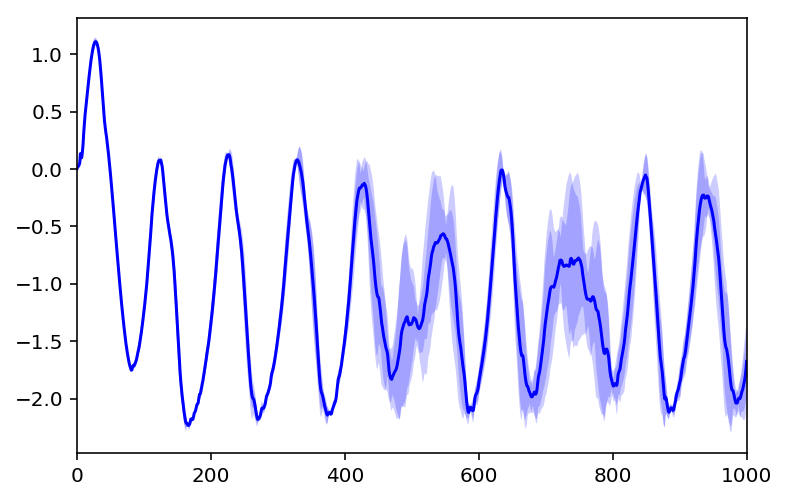

In [269]:
sns.tsplot(data=np.array(ack_states_data['vy']), ci=[50, 90], color="b")

/home/zadiq/dev/venvs/dl/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


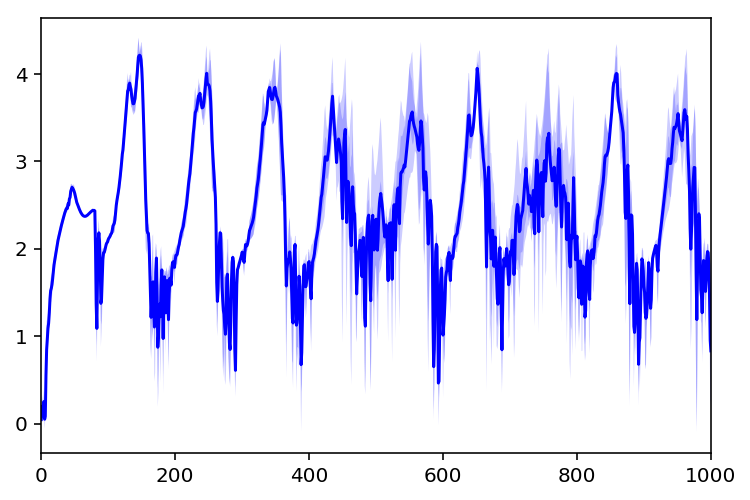

In [270]:
sns.tsplot(data=np.array(ack_states_data['omega']), ci=[50, 90], color="b")

/home/zadiq/dev/venvs/dl/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


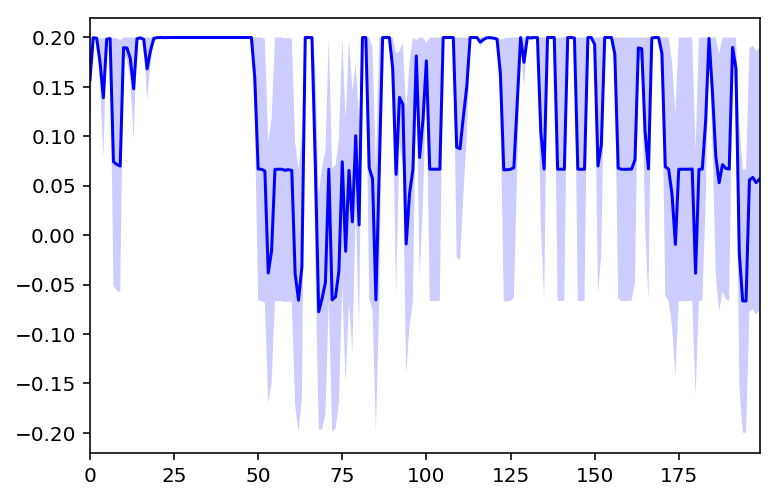

In [282]:
# steering: remove percentile but give space for height
sns.tsplot(data=np.array(ack_states_data['steering'])[:, 600:800], ci=[90], color="b")

## Reward Analysis

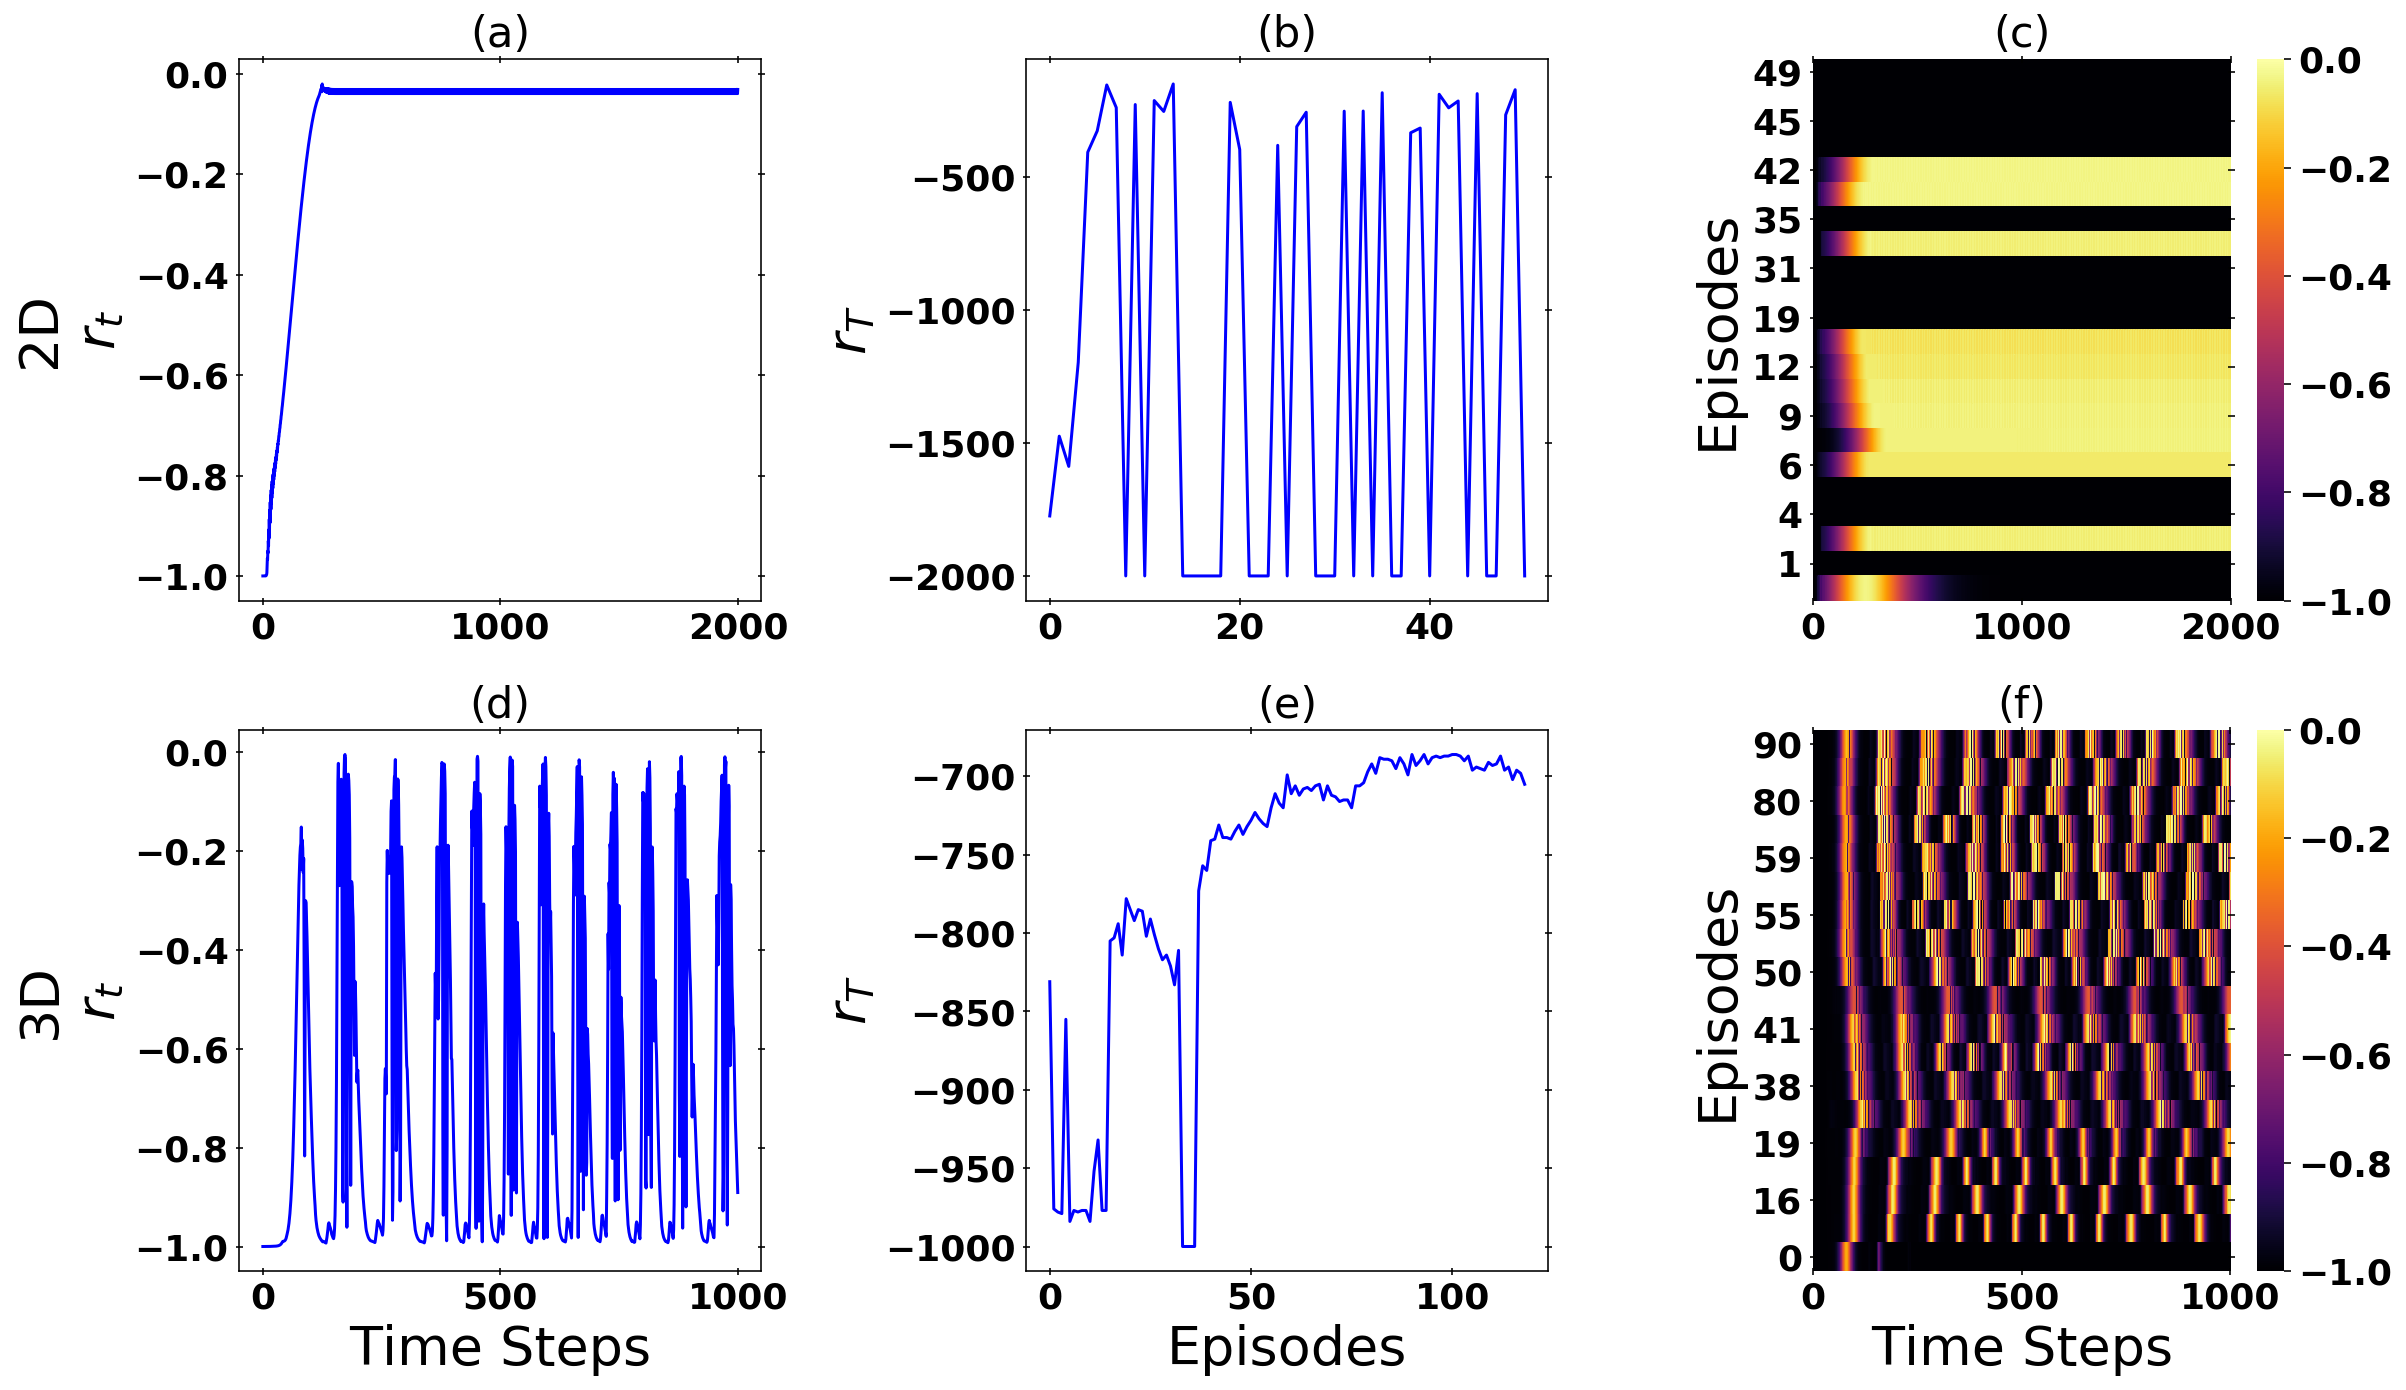

In [446]:
# Reward Analysis
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(17, 10))

#-----------------------------2D PLOTS-------------------------------------
top_row = axes[0]

#2D reward
top_row[0].plot(analysis['02-03-2019/ddpg_run_7'][1][41].inf_reward, color='b')
top_row[0].set_title("(a)")
top_row[0].set_ylabel("2D\n$r_t$", size=27)

#2D Reward per episode
sns.lineplot(data=run_7_total_rewards[1:,2], color='b', ax=top_row[1])
top_row[1].set_title("(b)")
top_row[1].set_ylabel("$r_T$", size=27)

#reward per state per episode
sns.heatmap(ep_step_df_2d[::-1],  cmap="inferno", ax=top_row[2], vmin=-1, vmax=0)
top_row[2].xaxis.set_major_locator(plt.MultipleLocator(1000))
top_row[2].xaxis.set_major_formatter(ticker.ScalarFormatter())
top_row[2].tick_params('both', rotation=0)
top_row[2].set_title("(c)")
top_row[2].set_ylabel("Episodes", size=27)


#-----------------------------3D PLOTS-------------------------------------
bot_row = axes[1]

#2D reward
bot_row[0].plot(thd_models[90].inf_reward, color='b')
bot_row[0].set_xlabel("Time Steps", size=27)
bot_row[0].set_ylabel("3D\n$r_t$", size=27)
bot_row[0].set_title("(d)")


#2D Reward per episode
sns.lineplot(data=run_3_total_rewards[1:,2], color='b', ax=bot_row[1])
bot_row[1].set_xlabel("Episodes", size=27)
bot_row[1].set_ylabel("$r_T$", size=27)
bot_row[1].set_title("(e)")

#reward per state per episode
sns.heatmap(ep_step_df_3d[::-1],  cmap="inferno", ax=bot_row[2], vmin=-1, vmax=0)
bot_row[2].set_xlabel("Time Steps", size=27)
bot_row[2].set_ylabel("Episodes", size=27)
bot_row[2].xaxis.set_major_locator(plt.MultipleLocator(500))
bot_row[2].xaxis.set_major_formatter(ticker.ScalarFormatter())
bot_row[2].tick_params('both', rotation=0)
bot_row[2].set_title("(f)")

#---------------------------all---------------------------
for ax in axes.flat:
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')        
    ax.tick_params('both', direction='inout')

fig.tight_layout()
fig.savefig(f"images/reward_analysis.eps", format="eps", dpi=1000)
fig.savefig(f"images/reward_analysis.png", format="png", dpi=500)

## Action Analysis

/home/zadiq/dev/venvs/dl/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


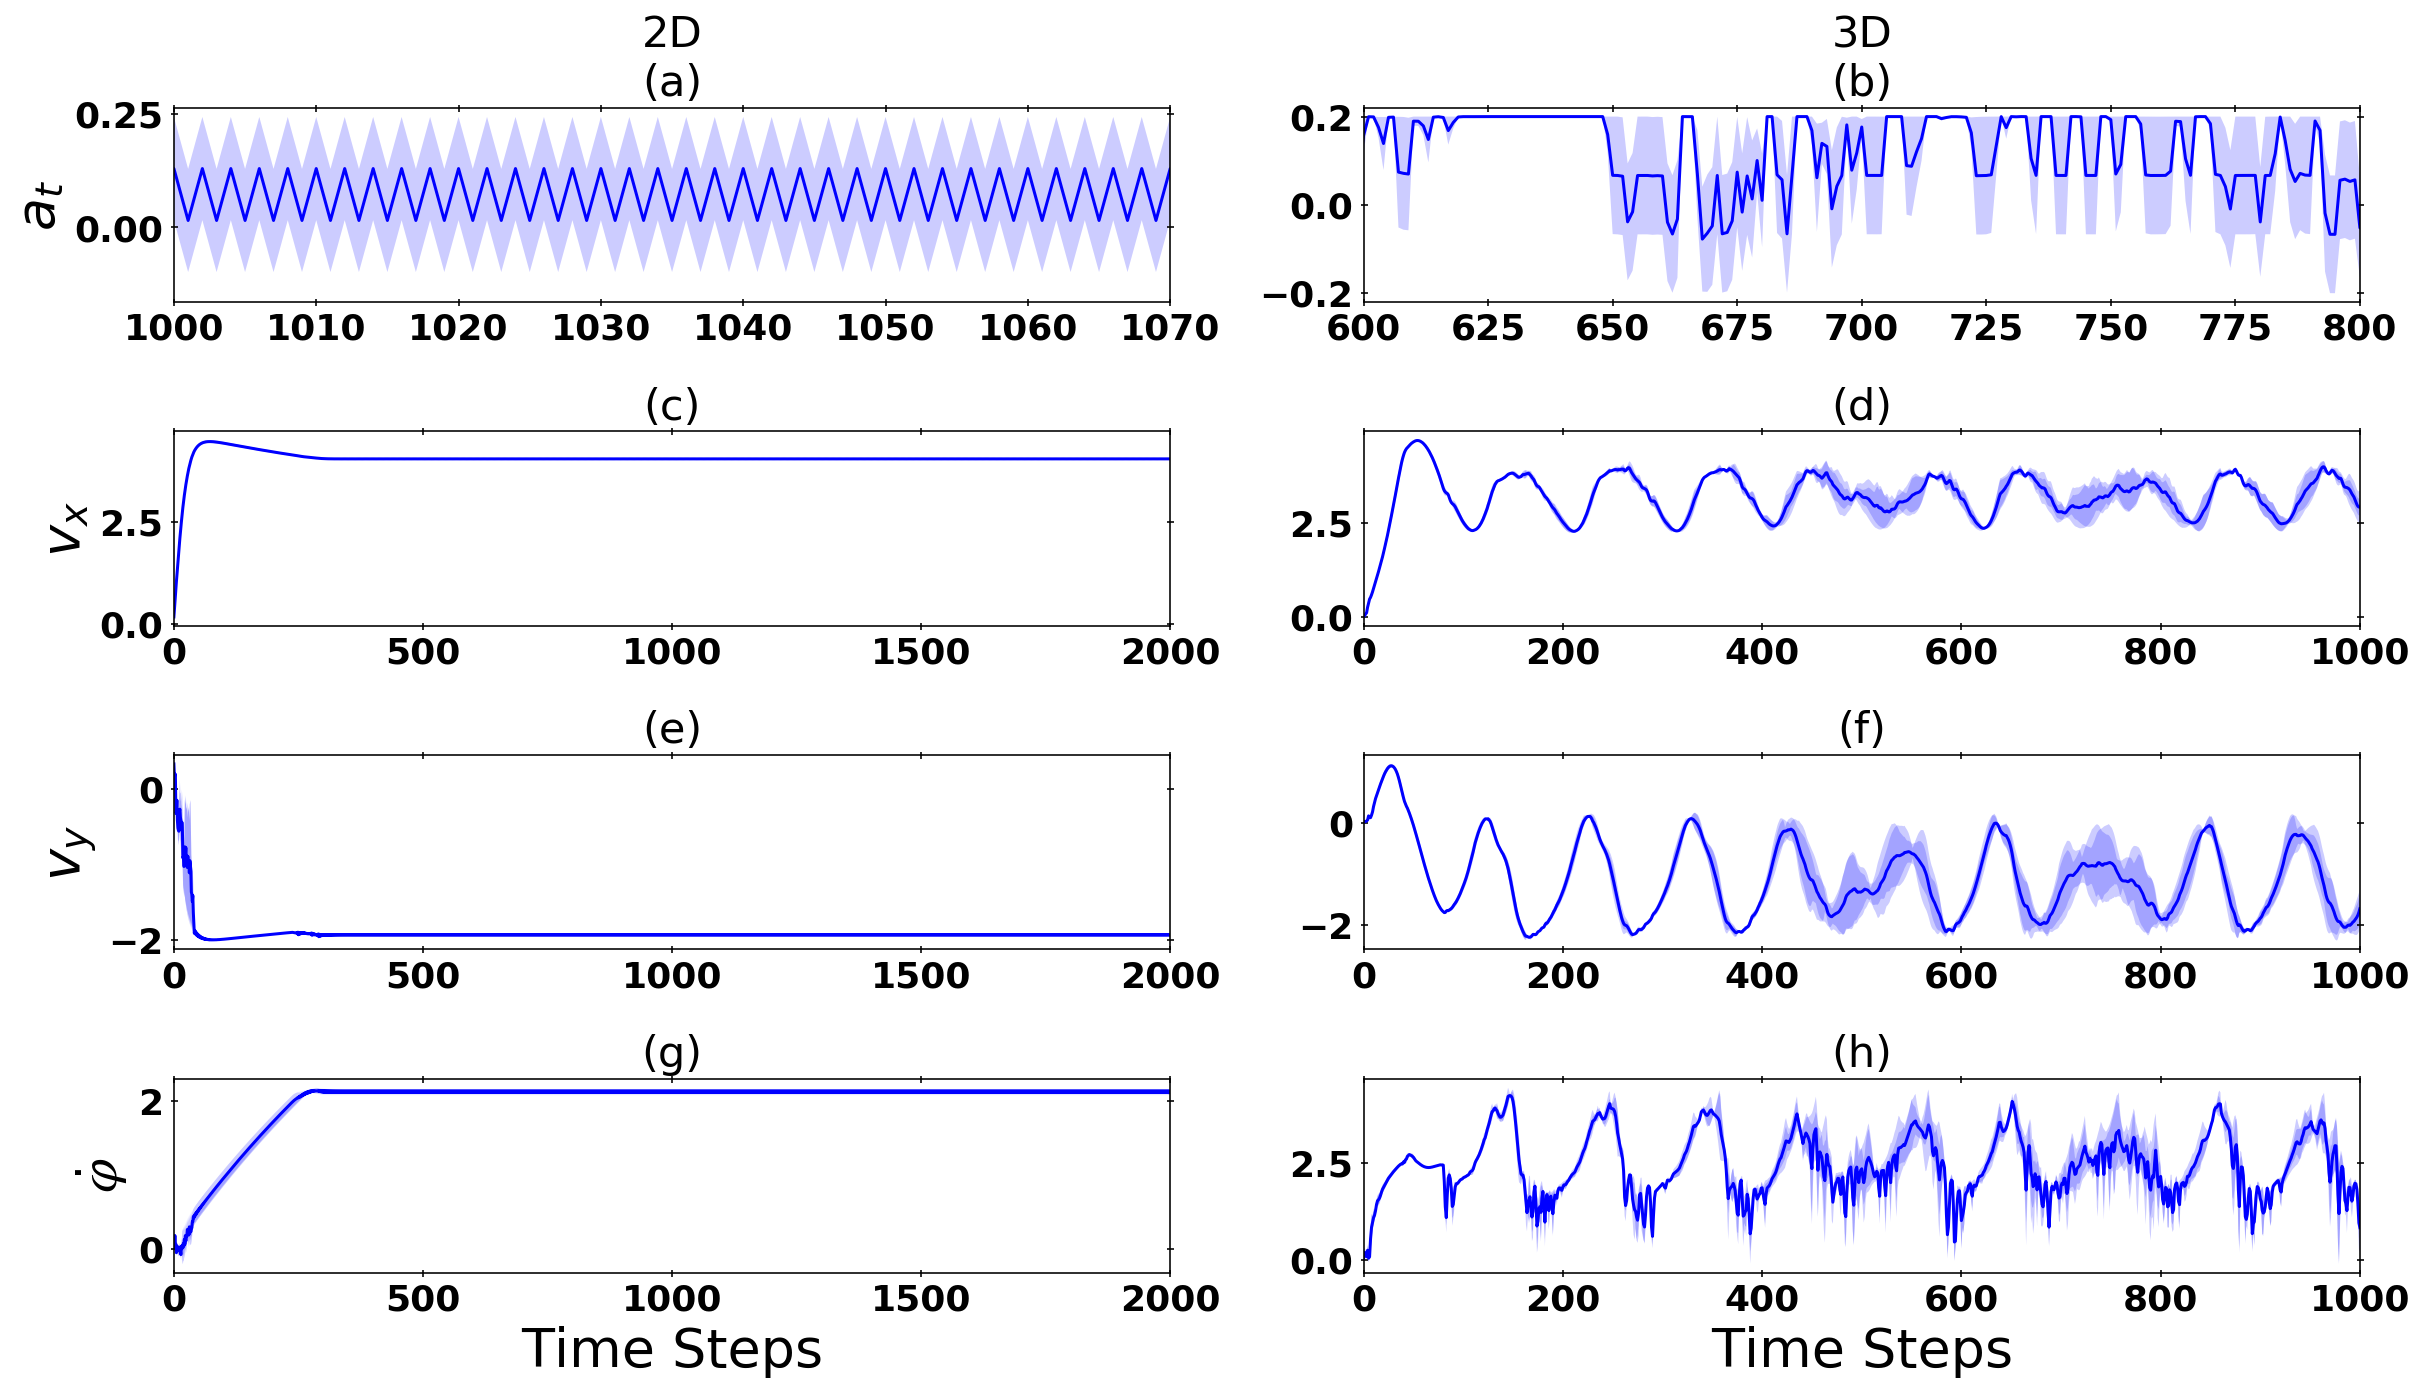

In [447]:
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(17, 10))

# --------------actions ------------------
act = axes[0]

#2d action
sns.tsplot(data=np.array(states_data['steering']), ci=[50], color="b", ax=act[0])
# act[0].set_xticklabels(range(1000, 1071))
# act[0].xaxis.set_major_formatter(ticker.ScalarFormatter())
sns.tsplot(data=np.array(ack_states_data['steering']), ci=[90], color="b", ax=act[1])
act[0].set_ylabel("$a_t$", size=27)
act[0].set_xlim(1000, 1070)
act[1].set_xlim(600, 800)
# [:, 600:800]
act[0].set_title("2D\n(a)")
act[1].set_title("3D\n(b)")

# --------------vx ------------------
vx = axes[1]
sns.tsplot(data=np.array(states_data['vx']), ci=[50, 90], color="b", ax=vx[0])
sns.tsplot(data=np.array(ack_states_data['vx']), ci=[50, 90], color="b", ax=vx[1])
vx[0].set_ylabel("$v_x$", size=27)
vx[0].xaxis.set_major_locator(plt.MultipleLocator(500))
vx[0].xaxis.set_major_formatter(ticker.ScalarFormatter())
vx[0].set_xlim(0, 2000)
vx[0].set_title("(c)")
vx[1].set_title("(d)")

# --------------vy ------------------
vy = axes[2]
sns.tsplot(data=np.array(states_data['vy']), ci=[50, 90], color="b", ax=vy[0])
sns.tsplot(data=np.array(ack_states_data['vy']), ci=[50, 90], color="b", ax=vy[1])
vy[0].set_ylabel("$v_y$", size=27)
vy[0].set_title("(e)")
vy[1].set_title("(f)")
vy[0].xaxis.set_major_locator(plt.MultipleLocator(500))
vy[0].xaxis.set_major_formatter(ticker.ScalarFormatter())
vy[0].set_xlim(0, 2000)

# -------------- omega ------------------
ome = axes[3]
sns.tsplot(data=np.array(states_data['omega']), ci=[50, 90], color="b", ax=ome[0])
sns.tsplot(data=np.array(ack_states_data['omega']), ci=[50, 90], color="b", ax=ome[1])

ome[0].set_xlabel("Time Steps", size=27)
ome[0].set_ylabel("$\dot{𝜑}$", size=27)
ome[1].set_xlabel("Time Steps", size=27)
ome[0].set_title("(g)")
ome[1].set_title("(h)")
ome[0].xaxis.set_major_locator(plt.MultipleLocator(500))
ome[0].xaxis.set_major_formatter(ticker.ScalarFormatter())
ome[0].set_xlim(0, 2000)

for ax in axes.flat:
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')        
    ax.tick_params('both', direction='inout')

fig.tight_layout()
fig.savefig(f"images/action_analysis.eps", format="eps", dpi=200)
fig.savefig(f"images/action_analysis.png", format="png", dpi=500)